# Chapter 11 Model Evaluation

## 11.1 Cross-Validating Models
评估模型在现实世界中的性能。

In [1]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

digits = datasets.load_digits()
features = digits.data
target = digits.target
standardizer = StandardScaler()
logit = LogisticRegression()
pipeline = make_pipeline(standardizer, logit)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

cv_results = cross_val_score(pipeline, features, target, cv=kf, 
                             scoring='accuracy', n_jobs=-1)
cv_results

array([0.97222222, 0.97777778, 0.95555556, 0.95      , 0.95555556,
       0.98333333, 0.97777778, 0.96648045, 0.96089385, 0.94972067])

#### 使用KFCV的注意事项：
* 数据独立同分布。
* 每一个fold中各类别的比例要大致和总体中的比例一致，在sklearn中可以使用StratifiedKFold代替KFold。
* 在运用验证或交叉验证时，基于训练集对数据进行预处理，然后同时把变换应用到训练集和测试集中。

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1,
                                                   random_state=1)
standardizer.fit(X_train)
X_train_std = standardizer.transform(X_train)
X_test_std = standardizer.transform(X_test)

原因是：假定测试集是未知数据。如果我们使用来自训练和测试集的观察值来匹配两个预处理器，那么来自测试集的一些信息就会泄漏到训练集中。此规则适用于任何预处理步骤，如特征选择。

## 11.2 Creating a Baseline Regression Model
用一个简单基线回归模型来对比你的模型。

In [19]:
from sklearn.datasets import load_boston
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
print(dummy.score(X_test, y_test))

ols = LinearRegression()
ols.fit(X_train, y_train)
print(ols.score(X_test, y_test))

-0.001119359203955339
0.635463843320211


## 11.3 Creating a Baseline Classification Model
可以用来量度一个分类器是否比随机猜测好。

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train, y_train)
print(dummy.score(X_test, y_test))

classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
print(classifier.score(X_test, y_test))

0.42105263157894735
0.9736842105263158


## 11.4 Evaluating Binary Classifier Predictions
评估一个已经训练好的分类模型。

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=3, n_informative=3,
                          n_redundant=0, n_classes=2, random_state=1)

logit = LogisticRegression(solver='liblinear')
cross_val_score(logit, X, y, cv=3, scoring='accuracy')

array([0.95170966, 0.9580084 , 0.95558223])

评分标准有：accuracy、precision、recall、f1  
f1是对precision和recall的平衡，表示对标记为正类的结果有多少是真的正类。  

如果已经有实际值和预测值，可以直接使用一下的评分方法：

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1,
                                                    random_state=1)
y_hat = logit.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_hat)

0.947

## 11.5 Evaluating Binary Classifier Thresholds
评估二元分类器和多概率阈值

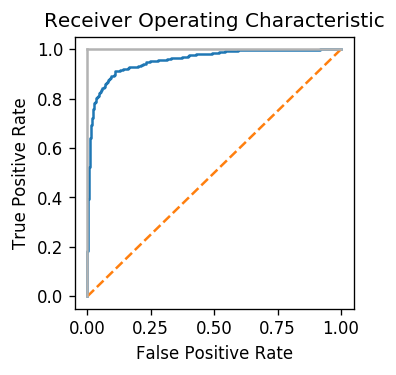

In [7]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, n_features=10, n_informative=3,
                          n_redundant=0, n_classes=2, random_state=6)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1,
                                                    random_state=1)
logit = LogisticRegression(solver='liblinear')
logit.fit(X_train, y_train)
y_proba = logit.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(y_test, y_proba)

plt.figure(figsize=(3, 3), dpi=120)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.7')
plt.plot([1, 1], c='.7')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

* 曲线越接近灰色线越好;  
* 模型越好，曲线越高，曲线下的面积就越大。曲线下的面积越接近1，模型越好：

In [86]:
roc_auc_score(y_test, y_proba)

0.9567877506566725

## 11.6 Evaluating Multiclass Classifier Predictions
交叉验证能评估能分两类以上的分类器

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=3, n_informative=3,
                          n_redundant=0, n_classes=3, random_state=1)

logit = LogisticRegression(solver='liblinear', multi_class='auto')
cross_val_score(logit, X, y, cv=3, scoring='f1_macro')

array([0.83613125, 0.82562258, 0.81293539])

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

X, y = make_classification(n_samples=10000, n_features=3, n_informative=3,
                          n_redundant=0, n_classes=3, random_state=1)

logit = LogisticRegression(solver='liblinear', multi_class='auto')
print(f"{cross_val_score(logit, X, y, cv=3, scoring='f1_macro').mean():0.2f}")
y_pred = logit.fit(X, y).predict(X)
print(classification_report(y, y_pred))

0.82
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      3327
           1       0.84      0.85      0.84      3336
           2       0.84      0.85      0.85      3337

    accuracy                           0.83     10000
   macro avg       0.82      0.83      0.82     10000
weighted avg       0.82      0.83      0.83     10000



## 11.7 Visualizing a Classifier's Performance
使用混淆矩阵来比较预测类别和实际类别

(0.0, 3.0, 3.0, 0.0)

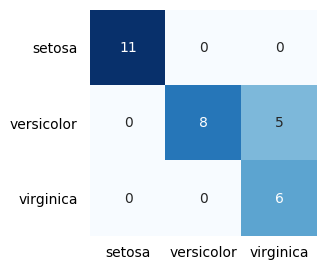

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

iris = datasets.load_iris()
X, y = iris.data, iris.target
class_names = iris.target_names
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
clf = LogisticRegression(solver='liblinear', multi_class='auto')
y_pred = clf.fit(X_train, y_train).predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3), dpi=100)
sns.heatmap(matrix, annot=True, cbar=None, cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', left=False, bottom=False, labelrotation=0)
plt.axis('equal')

* 图中的列代表预测值数量，行代表实际值数量。
* 好的模型使得数值都在对角线上，其余全为0。
* 混淆矩阵很容易看出错误出在哪里，图中有5个versicolor类被错误预测为virginica类。
* 可以看出模型对类别之间的区分能力，例如：模型更容易区分virginica类和setosa类，而很难区分virginica类和versicolor类。
* 混淆矩阵适用于任意多的分类。

## 11.8 Evaluating Regression Models
使用均方差（MSE）评估回归模型的性能

In [132]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
# Generate features matrix, target vector 
features, target = make_regression(n_samples = 100,
                                   n_features = 3,
                                   n_informative = 3,
                                   n_targets = 1,
                                   noise = 50,
                                   coef = False,
                                   random_state = 1)
# Create a linear regression object 
ols = LinearRegression()
# Cross-validate the linear regression using (negative) MSE
print('MSE:', cross_val_score(ols, features, target, cv=3, scoring='neg_mean_squared_error'))

# Cross-validate the linear regression using R-squared 
print('R-squared:', cross_val_score(ols, features, target, cv=3, scoring='r2'))

MSE: [-1718.22817783 -3103.4124284  -1377.17858823]
R-squared: [0.87804558 0.76395862 0.89154377]


* 因为sklearn的评分默认是越大越好，而均方差（MSE）是越小越好，所以该scoring参数要用负的均方差
* $R^2$的分数是越接近1越好。

## 11.9 Evaluating Clustering Models
用轮廓系数来评估非监督学习

In [4]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=1000,
                 n_features=10,
                 centers=2,
                 cluster_std=0.5,
                 shuffle=True,
                 random_state=1)
model = KMeans(n_clusters=2, random_state=1).fit(X)
y_pred = model.labels_
print('sil:', silhouette_score(X, y_pred))
print('cvs:', cross_val_score(model, X, y_pred, cv=5, 
                              scoring='v_measure_score').mean())

sil: 0.8916265564072142
cvs: 1.0


* 轮廓系数公式为：$ s_{i} = \frac{b_{i} - a_{i}}{max(a_{i}, b_{i})} $
* 轮廓系数取值在-1到1之间，1表示稠密、独立性好的聚类。

## 11.10 Creating a Custom Evaluation Metric
自定义模型评估量度：  
使用sklearn.metrics.make_scorer()

## 11.11 Visualizing the Effect of Training Set Size
可视化训练集大小对评分的影响

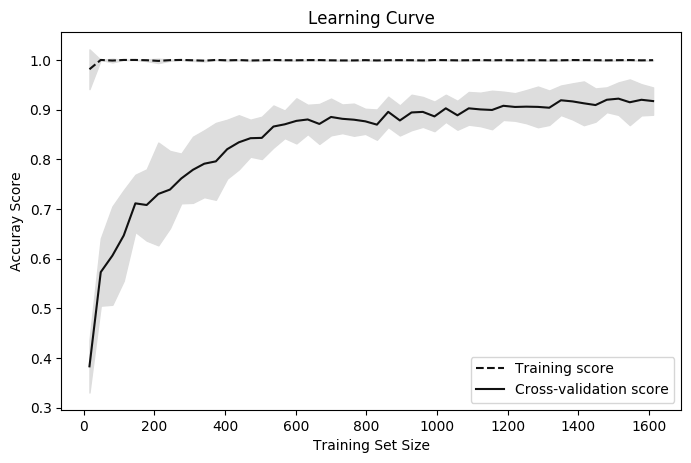

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

X, y = load_digits(return_X_y=True)
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(),
                                            X, y,
                                            cv=10,
                                            scoring='accuracy',
                                            n_jobs=-1,
                                            train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(train_sizes, train_mean, '--', c='#111111', label='Training score')
plt.plot(train_sizes, test_mean, c='#111111', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='#DDDDDD')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='#DDDDDD')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuray Score')
plt.legend()
plt.show()

从图中看出，增加训练集数量对可以增加准确度。

### 11.12 Creating a Text Report of Evaluation Metrics
用classification_report来快速描述一个分类器的性能。

In [55]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

iris = datasets.load_iris()
X, y = iris.data, iris.target
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1)
clf = LogisticRegression(solver='liblinear', multi_class='auto')
y_pred = clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        14
  versicolor       1.00      0.72      0.84        18
   virginica       0.72      1.00      0.84        13

    accuracy                           0.89        45
   macro avg       0.91      0.91      0.89        45
weighted avg       0.92      0.89      0.89        45



## 11.13 Visualizing the Effect of Hyperparameter Values
通过绘制验证曲线来了解：当改变一些超参数后模型的性能如何变化。

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

X, y = load_digits(return_X_y=True)
# 创建参数值范围
param_range = np.arange(1, 100, 2)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),
    X, y,
    param_name='n_estimators',
    param_range=param_range,
    cv=3, scoring='accuracy',
    n_jobs=-1
)

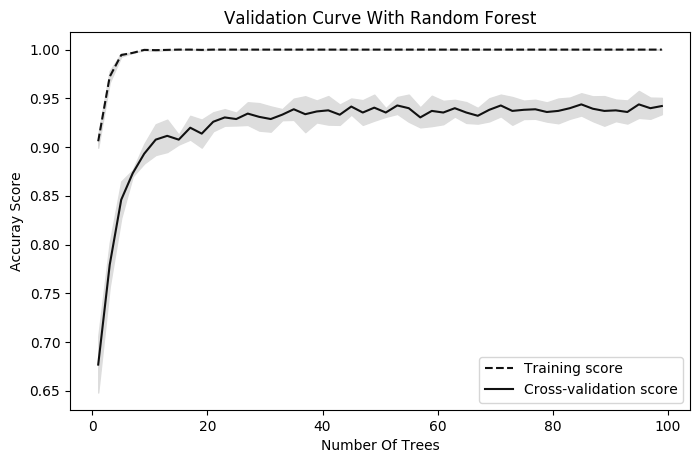

In [67]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(param_range, train_mean, '--', c='#111111', label='Training score')
plt.plot(param_range, test_mean, c='#111111', label='Cross-validation score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='#DDDDDD')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='#DDDDDD')
plt.title('Validation Curve With Random Forest')
plt.xlabel('Number Of Trees')
plt.ylabel('Accuray Score')
plt.legend()
plt.show()

# Chapter 12 Model Selection

## 12.1 Selecting Best Model Using Exhaustive Search
使用GridSearchCV：通过搜索一个范围的超参数来选择最好的模型。

In [89]:
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X, y = datasets.load_iris(return_X_y=True)
model = linear_model.LogisticRegression(solver='liblinear', multi_class='auto')
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hp = dict(C=C, penalty=penalty)
gs = GridSearchCV(model, hp, cv=5, n_jobs=-1)
best_model = gs.fit(X, y)

print('The best params:', best_model.best_params_)
print('The best score:', best_model.best_score_)

The best params: {'C': 7.742636826811269, 'penalty': 'l1'}
The best score: 0.98


## 12.2 Selecting Best Models Using Randomized Search
